<a href="https://colab.research.google.com/github/jinweiRao/MEng-Project/blob/master/Test_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import tensorflow
from tensorflow import keras
from keras import backend as K
from keras.optimizers import SGD, Adam,RMSprop
from keras.layers import Dense,Activation,Input
import numpy as np
import pandas as pd
from keras import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from keras import optimizers, regularizers
import seaborn as sns
from keras import callbacks
from scipy.stats.stats import pearsonr
import random
import matplotlib.pyplot
from sklearn.cluster import KMeans
from sklearn import tree
from tqdm import tqdm

## Build baseline_model

In [18]:
data=pd.read_csv('plant_A.csv')
data.head()

,lp,Temp,CaO,MgO,SiO2,Fe_total,MnO,Al2O3,TiO2,V2O5
0,4.736198,1649,40.0,8.63,7.8,27.5,3.38,0.91,0.45,1.473
1,4.436094,1654,39.6,9.99,9.2,23.0,4.14,2.60,0.68,1.945
2,4.499810,1664,44.8,8.80,11.0,20.2,3.45,1.58,0.76,2.070
3,4.140865,1680,42.4,8.10,11.5,21.1,3.76,2.47,0.88,2.161
4,4.081441,1671,48.8,11.73,11.8,13.3,3.26,1.48,0.78,1.976


In [19]:
trial_data = stddata.drop(['CaO'],axis =1).copy()

In [20]:
def stdarize_data(data):
    mean = data.describe().loc['mean'].values
    std = data.describe().loc['std'].values
    stddata = (data - mean)/std
    return stddata

In [21]:
stddata = stdarize_data(data)
stddata.loc[:,'lp'] = data.loc[:,'lp']
stddata.head()

,lp,Temp,CaO,MgO,SiO2,Fe_total,MnO,Al2O3,TiO2,V2O5
0,4.736198,0.009329,-0.671236,-0.439794,-2.922204,2.626815,-2.034799,-1.869831,-2.451391,-1.341048
1,4.436094,0.270513,-0.781774,0.555023,-2.118590,1.352351,-0.943029,1.682121,-1.622410,-0.383367
2,4.499810,0.792881,0.655222,-0.315442,-1.085373,0.559351,-1.934241,-0.461660,-1.334069,-0.129743
3,4.140865,1.628670,-0.008007,-0.827481,-0.798368,0.814244,-1.488914,1.408894,-0.901557,0.054895
4,4.081441,1.158539,1.760603,1.827804,-0.626165,-1.394827,-2.207183,-0.671835,-1.261984,-0.320468


In [22]:
act_list = ['sigmoid','tanh','softsign','softmax','relu','elu']
opt_list = ['adam','RMSprop','Adadelta','SGD']

In [23]:
def baseline_model(act,opt,nums):
    model = Sequential()
    model.add(Dense(nums, input_dim = 9, activation = act))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss='mae', optimizer = opt, metrics=['mse']) 
    return model

def baseline_model_2layer(act,opt,nums):
    model = Sequential()
    model.add(Dense(nums, input_dim = 9, activation = act))
    model.add(Dense(nums, input_dim = 9, activation = act))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss='mae', optimizer = opt, metrics=['mse']) 
    return model

In [24]:
def generate_model():
    model_list = []
    for act in act_list:
        for opt in opt_list:
            model_list.append(baseline_model(act,opt,16))
    return model_list

In [25]:
modelList = generate_model()

In [26]:
def cv(df,model):
    kf = KFold(n_splits = 5, random_state = 10, shuffle = False)
    splits = kf.split(df)
    comparision_list = []
    for train_index,test_index in splits:
        X_train = df.loc[train_index,'Temp':'V2O5'].values
        X_test = df.loc[test_index,'Temp':'V2O5'].values
        y_train = df.loc[train_index,'lp'].values
        y_test = df.loc[test_index,'lp'].values
        model.fit(X_train, y_train, epochs = 150, batch_size = 20, validation_data = (X_test,y_test),verbose = 0)
        prediction = model.predict(X_test).reshape(len(X_test),)
        comparision = {'prediction':prediction,'truth':y_test}
        comparision_list.append(comparision)
    return comparision_list

In [27]:
def modelsearch(modelList,df):
    result_list = [] 
    for model in modelList:
        result = cv(df,model)
        result_list.append(result)
    return result_list

In [29]:
allresult = modelsearch(modelList, stddata)

In [30]:
def get_result(data):
    R_list = []
    RMSE_list = []
    for model_index in range(len(data)):
        rmse_list = []
        r_list = []
        for k in range(5):
            pre = data[model_index][k]['prediction']
            truth = data[model_index][k]['truth']
            rmse = np.sqrt(sum((pre - truth)**2)/len(pre))
            r = pearsonr(pre,truth)[0]
            rmse_list.append(rmse)
            r_list.append(r)
        R_list.append(np.mean(r_list))
        RMSE_list.append(np.mean(rmse_list))
    return R_list, RMSE_list

In [31]:
def get_namelist():
    namelist = []
    for act in act_list:
        for opt in opt_list:
            namelist.append(act +'-'+ opt)
    return namelist

In [32]:
namelist = get_namelist()
namelist[:5]

['sigmoid-adam',
 'sigmoid-RMSprop',
 'sigmoid-Adadelta',
 'sigmoid-SGD',
 'tanh-adam']

In [38]:
all_final = get_result(allresult)

In [43]:
def plot_result(data):
    plt.figure(figsize = (9,9))
    p1 = plt.barh(y = range(24), width = data[0], height = 0.35, label = 'R')
    p2 = plt.barh(y = range(24), width = [0.1/i for i in data[1]], height = 0.35, label = '0.3/RMSE',left = data[0])
    #plt.xlim(0,0.95,0.1)
    plt.yticks(range(24),(namelist))
    plt.ylabel('model_name',fontsize = 14)
    plt.legend()
    plt.show()

In [45]:
all_final

([0.5419487574179815,
  0.5459415910922546,
  0.5434439923086737,
  0.5471639119517505,
  0.5390854909686766,
  0.5383071718321176,
  0.5382245516264538,
  0.5429675393774266,
  0.5350389030243565,
  0.537429010551022,
  0.5399834669433786,
  0.5436871693187507,
  0.5382572563041632,
  0.5444876394624725,
  0.5408384175443677,
  0.54496717420558,
  0.538724625302892,
  0.5285048270149953,
  0.5325718360022312,
  0.5260535991823355,
  0.5380373230947955,
  0.5275668689532849,
  0.5387047134576814,
  0.5397518023638089],
 [0.25852792090671245,
  0.25672070573606864,
  0.26120496413979094,
  0.25647634072912484,
  0.2582500609400841,
  0.2599448112627547,
  0.258639205061929,
  0.26209860781925715,
  0.25939236043052527,
  0.26057367852190466,
  0.2578780117836829,
  0.25800640475579656,
  0.259451650701386,
  0.25859979483360784,
  0.25856625907494685,
  0.2582184568495666,
  0.25848909662848474,
  0.2622272181478034,
  0.2613150421340538,
  0.26429741577071475,
  0.25990970577560446,
  

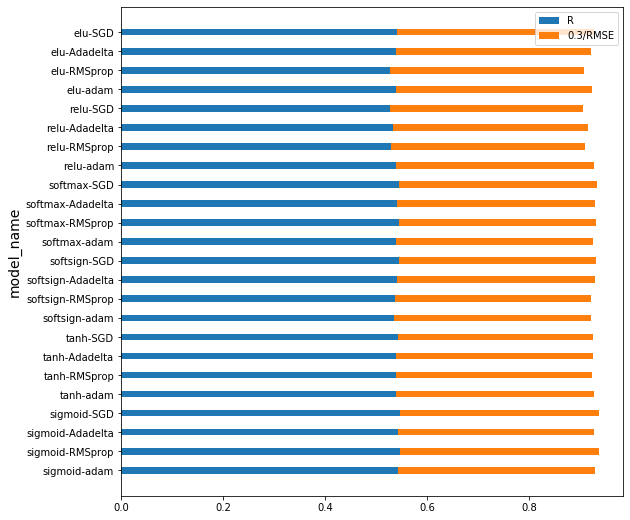

In [44]:
plot_result(all_final)

In [52]:
tru = allresult[1][0]['truth']
pre = allresult[1][0]['prediction']

In [270]:
def cv_result(data):
    rmse_list = []
    r_list = []
    for k in range(5):
        pre = data[k]['prediction']
        truth = data[k]['truth']
        rmse = np.sqrt(sum((pre - truth)**2)/len(pre))
        r = pearsonr(pre,truth)[0]
        rmse_list.append(rmse)
        r_list.append(r)
    return np.mean(rmse_list), np.mean(r_list)

In [317]:
cv_result(benchmark)

(0.8443735002957752, 0.5408520997419529)

In [316]:
cv_result(orginal)

(1.71648575090252, 0.23005407621299012)

In [401]:
model.fit(X_train,y_train, epochs = 150, batch_size = 20, verbose = 0, validation_data = (X_test,y_test))
pre2 = model.predict(X_test)

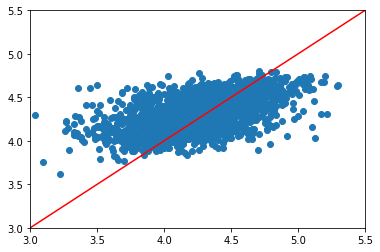

In [53]:
plt.scatter(x = tru, y = pre)
plt.ylim(3,5.5)

plt.xlim(3,5.5)

plt.plot([3,5.5],[3,5.5],color = 'red')


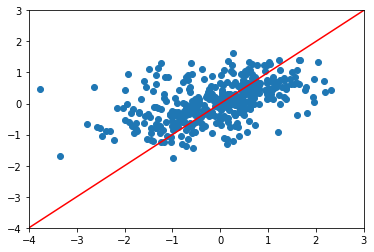

In [397]:
plt.scatter(x = y_test, y = pre2)
plt.ylim(-4,3)
plt.xlim(-4,3)
plt.plot([-4,3],[-4,3],color = 'red')

0.20653823

In [409]:
pre22 =( pre2 - pre2.mean())/pre2.std()
y2 = (y_test - y_test.mean())/y_test.std()
np.sqrt((sum((pre22.reshape(len(y_test),) - y2)**2))/len(y_test))

1.023762501261837

In [412]:
pearsonr(pre22,y2.values.reshape(-1,1))

(array([0.47529801]), array([7.03002117e-24]))

In [372]:
np.sqrt((sum((pre.reshape(len(y_test),) - y_test)**2))/len(y_test))

0.9078047181806805

In [373]:
pearsonr(pre,y_test.values.reshape(-1,1))

(array([0.49570273]), array([3.92512682e-26]))

In [ ]:
plt.hist(stddata.loc[''])

In [457]:
error = M1_result[0][0]['prediction'] - M1_result[0][0]['truth']

In [470]:
[1,2,3] + []

[1, 2, 3]

### error histgram

In [471]:
def get_error(data):
    error = []
    for k in range(5):
        temp = []
        temp = data[k]['prediction'] - data[k]['truth']
        temp = temp.tolist()
        error += temp
    return error

In [477]:
error = (get_error(M1_result[6])+get_error(M2_result[-11])+get_error(M3_result[12])+get_error(M4_result[-10])
        +get_error(M5_result[7])+get_error(M6_result[-2])+get_error(M7_result[-7])+get_error(M8_result[9]))

(array([2.000e+00, 0.000e+00, 4.000e+00, 6.000e+00, 1.400e+01, 2.200e+01,
        4.600e+01, 1.040e+02, 1.420e+02, 2.460e+02, 4.720e+02, 9.060e+02,
        1.476e+03, 1.921e+03, 2.080e+03, 1.856e+03, 1.496e+03, 1.040e+03,
        6.960e+02, 4.450e+02, 2.970e+02, 1.950e+02, 1.480e+02, 9.400e+01,
        5.500e+01, 4.100e+01, 2.700e+01, 8.000e+00, 3.000e+00, 4.000e+00]),
 array([-4.        , -3.73333333, -3.46666667, -3.2       , -2.93333333,
        -2.66666667, -2.4       , -2.13333333, -1.86666667, -1.6       ,
        -1.33333333, -1.06666667, -0.8       , -0.53333333, -0.26666667,
         0.        ,  0.26666667,  0.53333333,  0.8       ,  1.06666667,
         1.33333333,  1.6       ,  1.86666667,  2.13333333,  2.4       ,
         2.66666667,  2.93333333,  3.2       ,  3.46666667,  3.73333333,
         4.        ]),
 <a list of 30 Patch objects>)

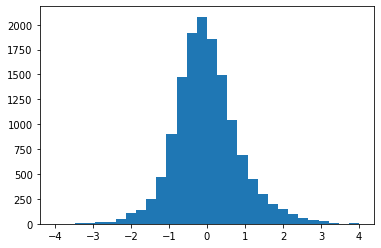

In [484]:
plt.hist(error,bins = 30 , range = (-4,4))